# Caltech CS159 Spring 2022, Assignment 1
Written by Christopher Yeh

## Logistics
- Released: April 7, 2022
- Due: April 13, 2022, 11:59pm PDT on Gradescope
- Please submit a PDF of with answers to the 5 questions listed in this Colab notebook. Do NOT submit a printout of this Colab Notebook.
- This assignment is worth 2% of your grade in the course.

## Overview

In this assignment, you will train a Graph Attention Network to predict whether certain molecules inhibits HIV virus replication. This is an example of a graph-level prediction task, where an input is a graph representing a molecule, and the classification label is binary (0 = does not inhibit HIV, 1 = inhibits HIV).

We will use the `ogb-molhiv` dataset from the Stanford Open Graph Benchmark. This dataset contains 41,127 graphs.

From https://ogb.stanford.edu/docs/graphprop/:

> Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.
>
> [...]
>
> The task is to predict the target molecular properties as accurately as possible, where the molecular properties are cast as binary labels, e.g, whether a molecule inhibits HIV virus replication or not.

We will use ROC-AUC as the evaluation metric.

This assignment assumes that you are familiar with PyTorch. If you are not familiar with PyTorch, please check out the [Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html) tutorial.

## Install Packages

As of April 5, 2022, Google Colab comes with CUDA Version 11.2 and PyTorch version `1.10.0+cu111`. This notebook assumes those version numbers. We can check the version numbers using the following commands:

In [1]:
# Check CUDA version: should be 11.2
!nvidia-smi

Mon Jun 13 16:19:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
|  0%   44C    P8    28W / 420W |      1MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:AF:00.0 Off |                  N/A |
|  0%   

In [2]:
# Check PyTorch version: should be 1.10.0+cu111
import torch
torch.__version__

'1.11.0'

Next, we install the corresponding packages for PyTorch Geometric (PyG). The following commands should install:
- torch-scatter-2.0.9
- torch-sparse-0.6.13
- torch-geometric-2.0.4
- ogb-1.3.3

In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.1 MB/s eta 0:00:0000:0100:01
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 36.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616602 sha256=6ee7b049bfabac8b0401223170f27b31d44993a129823a42a926e6346564ad29
  Stored in directory: /home/jyang4/.cache/pip/wheels/ba/44/59/28a61b516dbc37ed93285752c61c2cf1724ba0a0dada6c1150
Successfully built torch-geometric


## Global Imports and Constants

In [3]:
from __future__ import annotations

# from Python standard library
import copy
from pprint import pprint

# third-party libraries
import matplotlib.pyplot as plt
import networkx as nx
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda:1


## Getting familiar with PyTorch Geometric Datasets

In PyTorch and PyG, a dataset is an indexable list of data examples. The class hierarchy for datasets is

- [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
    - [`pyg.data.Dataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Dataset)
        - [`ogb.graphproppred.PygGraphPropPredDataset`](https://ogb.stanford.edu/docs/home/)

In [4]:
# Load the dataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

In [5]:
# Let's examine some dataset properties
# - length: this attribute comes from torch.utils.data.Dataset
# - num_features/num_classes: these attributes come from pyg.data.Dataset
# - task_type: this attribute is unique to datasets from OGB
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Task type: {dataset.task_type}')

Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of node features: 9
Number of edge features: 3
Number of classes: 2
Task type: binary classification


Let's examine a single graph from the dataset. PyTorch Geometric represents a graph as a [`pyg.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object.

We can print the `data` object with `print(data)`, which gives a short summary about its attributes and their shapes:
```python
Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)
```
We see that this `data` object has the following 5 attributes:
- `edge_index`: the list of edges for the graph. Specifically, `edge_index` is a Tensor of shape `[2, num_edges]`, where each column is a list containing the source and destination nodes of an edge.
- `edge_attr`: a Tensor of shape `[num_edges, edge_features]`, which holds the edge features for each edge
- `x`: a Tensor of shape `[num_nodes, node_features]`, which holds the node features for each node
- `y`: a scalar graph label
- `num_nodes`: # of nodes in the graph

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph. For example, there are functions to check for isolated nodes in the graph (*i.e.*, nodes with no edges), self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), and whether the graph is directed.

In [6]:
# get the first graph in the dataset
data = dataset[0]
print(data)

# print some statistics about the graph
print('==============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# print node features from the first 5 nodes
print('==============================================================')
print('some node features:')
print(data.x[:5])

# print the first 5 edge features
print('some edge features:')
print(data.edge_attr[:5])

# print the first 5 edges
print('some edges:')
print(data.edge_index.T[:5])

# print the graph label
print('==============================================================')
print('label:', data.y)

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)
Number of nodes: 19
Number of edges: 40
Average node degree: 4.21
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
some node features:
tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [28,  0,  4,  2,  0,  0,  5,  0,  1]])
some edge features:
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0]])
some edges:
tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3]])
label: tensor([[0]])


You can convert a PyG graph into a [networkX](https://networkx.org/) graph to visualize the graph structure:

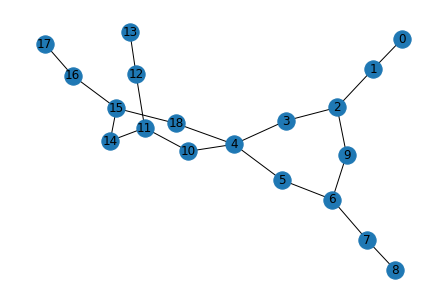

In [7]:
# Visualize the graph
G = pyg.utils.to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=True)

**Dataloaders and Batching**

This dataset comes with pre-defined train, validation, and test splits. We will wrap each dataset split with a [`pyg.loader.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader) (a subclass of `torch.utils.data.DataLoader`) which handles batching and data shuffling for us.

Iterating through a `DataLoader` yields `pyg.data.Batch` objects, which is how PyG handles mini-batching with graphs. To process a mini-batch of graphs in parallel, PyG combines a batch of graphs into a single disconnected graph data object [`pyg.data.Batch`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Batch). `pyg.data.Batch` is a subclass of `pyg.data.Data` and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node in the combined disconnected graph to the index of its corresponding graph within the mini-batch:

```python
batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]
```

This attribute is crucial for computing graph-level embeddings for each individual graph in a mini-batch.

In [8]:
# get the dataset splits, print out sizes
split_idx = dataset.get_idx_split()

print('split indices:')
pprint(split_idx)

for split in ('train', 'valid', 'test'):
    size = len(split_idx[split])
    print(f'{split}: {size} examples')

split indices:
{'test': tensor([    0,     1,     2,  ..., 10122, 10124, 10125]),
 'train': tensor([    3,     4,     5,  ..., 41124, 41125, 41126]),
 'valid': tensor([10127, 10129, 10132,  ..., 22785, 22786, 22788])}
train: 32901 examples
valid: 4113 examples
test: 4113 examples


In [9]:
train_loader = DataLoader(dataset[split_idx['train']], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx['valid']], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx['test']], batch_size=32, shuffle=False, num_workers=0)

## **Question 1: Warmup**

What is the distribution of labels in each of the train, valid, and test splits? That is, fill in the following table:

split | # and % of graphs with label 0 | # and % of graphs with label 1
------|---|---
train | ? | ?
valid | ? | ?
test  | ? | ?

The aim of this question is to help you get familiar with manipulating PyTorch Geometric datasets and DataLoaders.

In [ ]:
### TYPE YOUR CODE HERE (~10 lines)


### END CODE

## **Question 2: AUROC vs. Accuracy**

For this particular prediction task, we use AUROC as the performance metric. Based on what you observed from answering Question 1, why is AUROC a better metric than raw classification accuracy? If a model achieves 70% classification accuracy on the test set, is that a good model?

## Setting up the Graph Attention Network model

We use PyG's implementation of a [`GATv2Conv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATv2Conv) layer (from [Brody et al., 2022](http://arxiv.org/abs/2105.14491)) to construct a complete Graph Attention Network.

In [10]:
from ogb.graphproppred.mol_encoder import AtomEncoder

class GAT(torch.nn.Module):
    def __init__(self,
                 node_dim: int,
                 hidden_dim: int,
                 num_layers: int,
                 dropout: float):
        """
        Args
        - node_dim: int, dimension of input node features
        - hidden_dim: int, dimensions of hidden layers
        - num_layers: int, # of hidden layers
        - dropout: float, probability of dropout
        """
        super(GAT, self).__init__()

        # save all of the info
        self.node_dim = node_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # since there are a limited # of atoms, we first embed them into a
        # higher dimension using a lookup table
        self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)

        # a list of GATv2 layers, with dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(num_layers):
            layer = pyg_nn.GATv2Conv(in_channels=hidden_dim,
                                     out_channels=hidden_dim,
                                     dropout=dropout)
            self.convs.append(layer)
            self.bns.append(nn.BatchNorm1d(hidden_dim))

        # fully-connected final layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, data: pyg.data.Data) -> torch.Tensor:
        """
        Args
        - data: pyg.data.Batch, a batch of graphs

        Returns: torch.Tensor, shape [batch_size], unnormalized classification
            probability for each graph
        """
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch)

        x = self.atom_encoder(x)

        for l, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if l != self.num_layers - 1:
                x = self.bns[l](x)
                x = F.relu(x)

        x = pyg_nn.global_mean_pool(x, batch=batch)
        x = self.fc(x)
        return x

## Define training and evaluation functions

In [11]:
def train(model: nn.Module, device: torch.device | str,
          data_loader: DataLoader, optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module, pbar: tqdm) -> float:
    """Trains a GNN model.

    Args
    - model: nn.Module, GNN model, already placed on device
    - device: torch.device
    - data_loader: pyg.loader.DataLoader
    - optimizer: torch.optim.Optimizer
    - loss_fn: nn.Module

    Returns: (loss, acc)
    - loss: float, average per-graph loss across epoch
    - acc: float, accuracy
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    pbar.reset(len(data_loader))
    pbar.set_description('Training')

    for step, batch in enumerate(data_loader):
        all_labels.append(batch.y.detach())

        batch = batch.to(device)
        batch_size = batch.batch.max().item()

        preds = model(batch)
        all_preds.append(preds.detach().cpu())
        loss = loss_fn(preds, batch.y.to(torch.float32))
        total_loss += loss.item() * batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update()

    all_preds = (torch.cat(all_preds).view(-1) > 0).to(torch.int32)
    all_labels = torch.cat(all_labels).view(-1)
    acc = (all_preds == all_labels).sum() / len(all_labels)
    avg_loss = total_loss / len(all_labels)
    return avg_loss, acc

In [12]:
def eval(model: nn.Module, device: torch.device, loader: DataLoader,
         evaluator: Evaluator, pbar: tqdm) -> dict[str, float]:
    """Evaluates the AUROC of a model on a dataset split.

    Args
    - model: nn.Module, GNN model, already moved to device
    - device: torch.device
    - loader: DataLoader
    - evaluator: Evaluator from OGB
    - pbar: tqdm, progress bar

    Returns: dict, with one (key, value)
    - key is dataset.eval_metric (which in this case is 'rocauc')
    - value is the AUROC
    """
    model.eval()
    y_true = []
    y_pred = []

    pbar.reset(total=len(loader))
    pbar.set_description('Evaluating')

    for step, batch in enumerate(loader):
        y_true.append(batch.y.detach())

        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch)
        y_pred.append(pred.detach().cpu())
        pbar.update()

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    input_dict = {'y_true': y_true, 'y_pred': y_pred}
    return evaluator.eval(input_dict)

## Train GAT model

Using a model with 3 hidden layers, each with dimension 256, the time per epoch should be approximately as follows:

split | CPU | GPU
------|-----|----
train | 4m to train, 1m to evaluate | 1m to train, 15s to evaluate
valid | 30s | 2s
test  | 30s | 2s

## **Questions 3-4: Improving this GAT implementation**

This notebook has already implemented a simple 3-layer Graph Attention Network, and the default hyperparameters have been chosen such that the model should achieve >= 0.73 AUROC on the test set when trained for 30 epochs. (See the training output and plot at the end of this notebook.)

Familiarize yourself with the implementation of the GAT above.

**Question 3**

List 3 possible modifications to the network architecture or training procedure that could improve the existing implementation, and give intuitive justification for why each modifications might be helpful.

(There are more than 3 valid answers, but we are asking you to list only 3. The hint below already suggests 3 such possibilities, which you may use.)

Hints:
- Does the current implementation use edge features?
- What does Question 2 suggest about class balance during training? Note the different class balance between the train/val/test splits.
- What does Question 5 suggest about the use of the global mean-pooling layer?
- If you want to explore the possibilities more in depth, you are welcome to explore the official [OGB leaderboard](https://ogb.stanford.edu/docs/leader_graphprop/#ogbg-molhiv) for this task and explore what the best-performing networks do.

**Question 4**

Choose at least one possible modification that you described in your answer to Question 3, and implement that modification. Describe your modification in words and/or code. Include a plot of the train/val/test AUROC and training loss curves after you implement your modification(s). Did the modification(s) improve the test AUROC? Why or why not?

Hints:
- If you decide to use edge features, note that the raw edge features are integer-valued, whereas the `GATv2Conv` layer expects float32 values. You can use `edge_attr.to(torch.float32)` to convert the edge features to the right type. Alternatively, consider first embedding the raw edge features with the OGB `BondEncoder`. Look into `ogb.graphproppred.mol_encoder.BondEncoder`.

In [13]:
# instantiate the model
model = GAT(node_dim=dataset.num_node_features,
            hidden_dim=256,
            num_layers=3,
            dropout=0.3)
model = model.to(device)

# use the official OGB evaluator, which will compute AUROC for us
evaluator = Evaluator(name='ogbg-molhiv')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.BCEWithLogitsLoss()
num_epochs = 30

In [14]:
best_model = None
best_valid_auroc = 0

# track the train/valid AUROC and train loss across epochs of training
train_losses = []
train_aurocs = []
valid_aurocs = []

pbar = tqdm()

for epoch in range(1, 1 + num_epochs):
    loss, acc = train(model, device, train_loader, optimizer, loss_fn, pbar)

    train_result = eval(model, device, train_loader, evaluator, pbar)
    val_result = eval(model, device, valid_loader, evaluator, pbar)

    train_auroc, valid_auroc = train_result[dataset.eval_metric], val_result[dataset.eval_metric]
    if valid_auroc > best_valid_auroc:
        best_valid_auroc = valid_auroc
        best_model = copy.deepcopy(model)
    tqdm.write(f'Epoch {epoch:02d}, loss: {loss:.4f}, '
               f'train acc: {100 * acc:.2f}%, '
               f'train auroc: {train_auroc:.4f}, '
               f'valid auroc: {valid_auroc:.4f}')

    train_losses.append(loss)
    train_aurocs.append(train_auroc)
    valid_aurocs.append(valid_auroc)

0it [00:00, ?it/s]

Epoch 01, loss: 0.1555, train acc: 96.22%, train auroc: 0.7080, valid auroc: 0.6689
Epoch 02, loss: 0.1483, train acc: 96.24%, train auroc: 0.7350, valid auroc: 0.6672
Epoch 03, loss: 0.1459, train acc: 96.26%, train auroc: 0.7294, valid auroc: 0.6627
Epoch 04, loss: 0.1444, train acc: 96.23%, train auroc: 0.7509, valid auroc: 0.6693
Epoch 05, loss: 0.1443, train acc: 96.24%, train auroc: 0.7547, valid auroc: 0.7027
Epoch 06, loss: 0.1418, train acc: 96.20%, train auroc: 0.7486, valid auroc: 0.7244
Epoch 07, loss: 0.1423, train acc: 96.20%, train auroc: 0.7690, valid auroc: 0.7566
Epoch 08, loss: 0.1408, train acc: 96.22%, train auroc: 0.7726, valid auroc: 0.7159
Epoch 09, loss: 0.1405, train acc: 96.21%, train auroc: 0.7592, valid auroc: 0.7554
Epoch 10, loss: 0.1396, train acc: 96.20%, train auroc: 0.7686, valid auroc: 0.7055
Epoch 11, loss: 0.1394, train acc: 96.18%, train auroc: 0.7615, valid auroc: 0.6919
Epoch 12, loss: 0.1395, train acc: 96.21%, train auroc: 0.7685, valid auroc:

In [15]:
test_result = eval(best_model, device, test_loader, evaluator, pbar)
test_auroc = test_result[dataset.eval_metric]
print(f'Final test AUROC: {test_auroc:.4f}')

Final test AUROC: 0.7379


In [ ]:
def plot_epochs(train_aurocs: list[float], valid_aurocs: list[float],
                test_auroc: float, train_losses: list[float]) -> plt.Figure:
    """Plots train/valid/test AUROC on y-axis, training loss on right y-axis,
    against epoch on the x-axis.

    Args
    - train_aurocs/valid_aurocs: list of float, AUROC on train/val per epoch
    - test_auroc: float, final AUROC on test split
    - train_losses: list of float, training loss per epoch

    Returns: plt.Figure
    """
    num_epochs = len(train_losses)
    assert len(train_aurocs) == num_epochs
    assert len(valid_aurocs) == num_epochs
    epochs = list(range(1, 1 + num_epochs))

    fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
    ax.plot(epochs, train_aurocs, c='tab:blue', label='train AUROC')
    ax.plot(epochs, valid_aurocs, c='tab:orange', label='val AUROC')
    ax.axhline(test_auroc, c='tab:gray', label='test AUROC')
    ax.set(xlabel='epoch', ylabel='AUROC')
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))

    ax2 = ax.twinx()
    ax2.plot(epochs, train_losses, c='tab:green', label='train loss')
    ax2.set_ylabel('loss')
    ax2.legend(loc='lower left', bbox_to_anchor=(1.15, 0.1))
    return fig

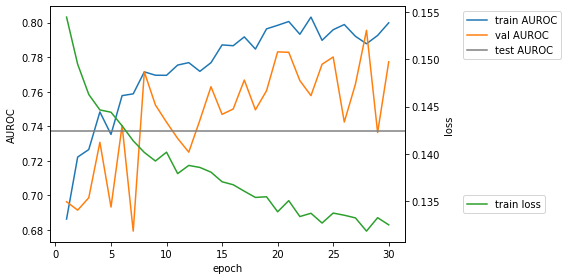

In [ ]:
fig = plot_epochs(train_aurocs, valid_aurocs, test_auroc, train_losses)
fig.savefig('auroc_loss_curves.pdf', pad_inches=0, bbox_inches='tight')

## Question 5: GNN Expressiveness

_This question is not directly related to the rest of this notebook and does not involve any coding._

In this question, we will compare different aggregation functions that are commonly used in designing GNN layers.

Let $x_u \in \mathbb{R}^d$ denote the feature vector for node $u$, and let $N_v$ denote the neighborhood of node $v$. We would like to compare:
- sum: $h = \sum_{u \in N_v} x_u$
- mean: $h = \frac{1}{|N_v|} \sum_{u \in N_v} x_u$
- max: $h_i = \max_{u \in N_v} (x_u)_i$, for all $i = 1, \dotsc, d$

It turns out that using _sum_ for aggregation is more "expressive" than either _mean_ or _max_.

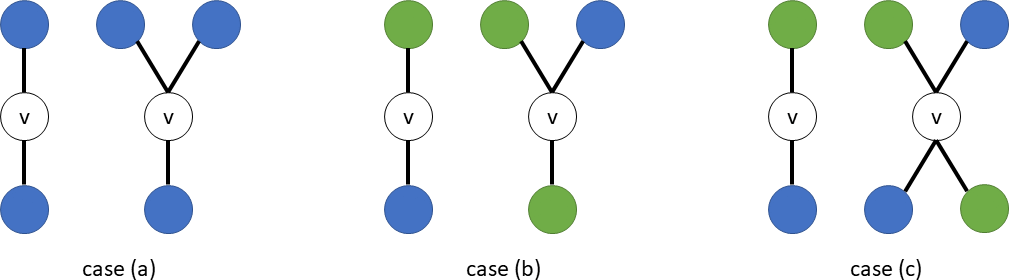

Look at the figure above. Nodes with the same color have the same feature vector. Each case (a,b,c) contains a pair of distinct graphs. Ideally, we would like `h` to be different when the neighborhood of `v` is different.

For each pair of graphs, decide whether `h` as computed by `sum`, `mean`, or `max` would be different between the two graphs. Explain.

## Bonus Question 6: Feedback Survey

If you filled out this survey, please say so on your HW submission. You will receive 2pts extra credit for this assignment.

https://forms.gle/kWKg6GosppNMQM9bA